Here we would be making forecast on the trends of a company using ARIMA. This simple Time series forecasting repository demonstrates how ARIMA performs in predicting the trends based on the closing prices. It would be a simple one, with no extra variables being involved, with ARIMA in its most basic form.

In [1]:
# import the required libraries

from numpy.random import seed
seed(1)
import pandas as pd
import numpy as np
#from pandas import read_csv
#from pandas import datetime
#from matplotlib import pyplot
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from sklearn.metrics import mean_squared_error
from math import sqrt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import scipy.stats
import pylab
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [7]:
# load the data. Make sure your data only contains Date and Close_Price columns. 
# Here I have set the frequency of observations as business days. Hence the weekdays for which we do not have data would be missing value.
# Meanwhile I have filled the missing values using 'ffill'.
# ‘ffill’ stands for ‘forward fill’ and will propagate last valid observation forward.

series = pd.Series(pd.read_csv('VOD.csv', parse_dates=['Date'], 
                                 index_col="Date").iloc[:,3]).astype(float).asfreq('b').fillna(method = 'ffill')
len(series)

1304

In [8]:
series

Date
2016-04-19    33.820000
2016-04-20    33.660000
2016-04-21    33.419998
2016-04-22    33.310001
2016-04-25    33.380001
                ...    
2021-04-12    18.680000
2021-04-13    18.639999
2021-04-14    18.660000
2021-04-15    18.660000
2021-04-16    18.950001
Freq: B, Name: Close, Length: 1304, dtype: float64

In [9]:
# know_your_data function is reated here to get idea what our data has.
# It would plot the trends, tell whether the series is stationary or not, and also help us see what trend type it is.
# Besides it would plot the acf and pacf plots which would give the expected values for various parameters required to fit the model.

def know_your_data(raw_data):
  plt.figure(figsize=(10,4))
  raw_data.plot()

  if raw_data.isna().sum()>0:
    print("Data has missing values")
  
  sns.displot(raw_data.values, kde = True)

  if sts.adfuller(raw_data)[1] < 0.05:
    print("Data is stationary")
  else:
    print("Data is not stationary")

  print("Check for trend")
  s_dec_additive = seasonal_decompose(raw_data.sort_index(), model = 'additive',  )
  s_dec_additive.plot()
  plt.show()
  s_dec_additive = seasonal_decompose(raw_data.sort_index(), model = 'multiplicative')
  s_dec_additive.plot()
  plt.show()

  sgt.plot_acf(raw_data, lags = 20, zero = False)
  plt.title('ACF')
  plt.show()

  sgt.plot_pacf(raw_data, lags = 20, zero = False, method = 'ols')
  plt.title('PACF')
  plt.show()

Data is not stationary
Check for trend


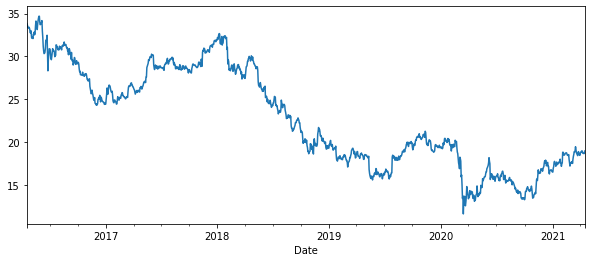

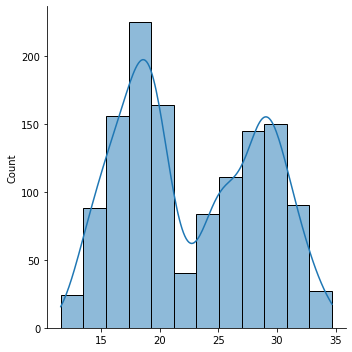

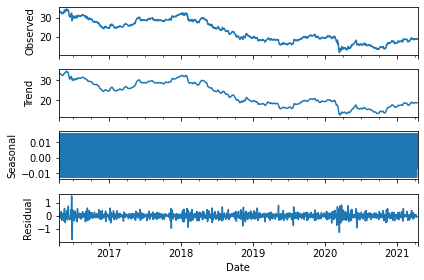

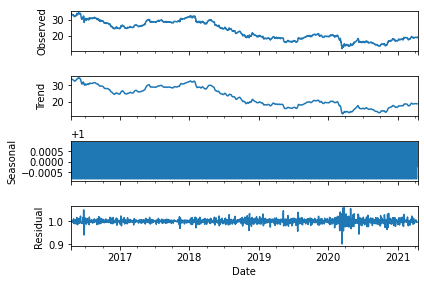

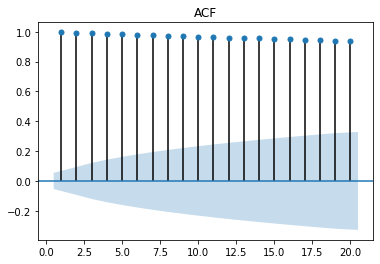

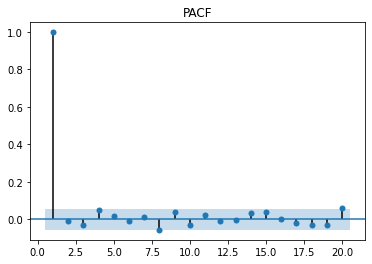

In [10]:
know_your_data(series)

We got to know that our data is not stationary as expected. Trend has overall increased. Also we got the required acf and pacf values. We got a range though, for pacf we can try 1, 3, 4 5, 6, for whichever our models shows good possibility of better results.

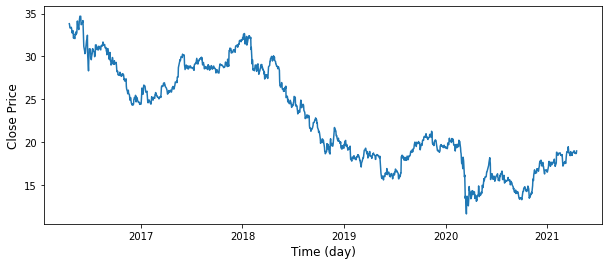

In [11]:
# Define a function to draw time_series plot
def timeseries (x_axis, y_axis, x_label):
    plt.figure(figsize = (10, 4))
    plt.plot(x_axis, y_axis)
    plt.xlabel(x_label, {'fontsize': 12}) 
    plt.ylabel('Close Price', {'fontsize': 12})
    

dataset = series.copy()
timeseries(series.index, dataset.values, 'Time (day)')

In [12]:
X = series.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

scaler = MinMaxScaler().fit(train.reshape(-1,1))
train_scaled = scaler.transform(train.reshape(-1,1))
test_scaled = scaler.transform(test.reshape(-1,1))

history = [x for x in train_scaled]
predictions = list()

# walk-forward validation
# here we fit the model in a way, we first fit and forecast one observation for the test_set. Then append with one more observation and fit and forecast for this appended list.

for t in range(len(test_scaled)):
	model = ARIMA(history, order=(4,1,2))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test_scaled[t]
	history.append(obs)

predictions = scaler.inverse_transform(predictions)
test = scaler.inverse_transform(test_scaled)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


In [13]:
def rmse(actual,predicted):
  return np.sqrt(np.mean(((actual- predicted)**2)))

def smape(actual, predicted):
  return (100/len(actual)) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

def mae(actual, predicted):
    return np.sum(np.median(np.abs(actual - predicted)))

In [14]:
def evaluate_prediction(predicted, actual, model_name):
  rmse_ = rmse(actual, predicted)
  smape_ = smape(actual, predicted)
  mae_ = mae(actual, predicted)

  print(model_name + ':')
  print('Mean Absolute Error: {:.4f}'.format(mae_))
  print('Root Mean Square Error: {:.4f}'.format(rmse_))
  print('SMAPE: {:.4f}'.format(smape_))
  print('')

evaluate_prediction(predictions[30:], test[30:], 'ARIMA')

ARIMA:
Mean Absolute Error: 0.1577
Root Mean Square Error: 0.3000
SMAPE: 1.3276



We see good results. Even better than the results got when same dataset was modeled using LSTM and GRU.

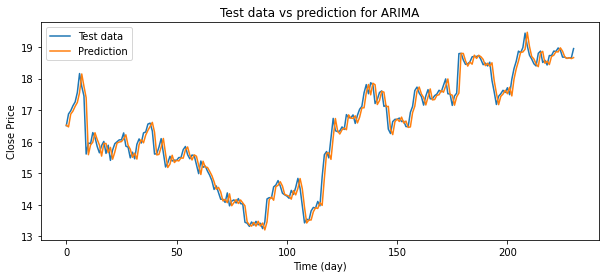

In [15]:
def plot_future(predicted, actual, model_name):
  plt.figure(figsize=(10, 4))
  
  range_future = len(predicted)

  plt.plot(np.arange(range_future), np.array(actual), label='Test data')
  plt.plot(np.arange(range_future), np.array(predicted),label='Prediction')

  plt.title('Test data vs prediction for ' + model_name)
  plt.legend(loc='upper left')
  plt.xlabel('Time (day)')
  plt.ylabel('Close Price')

plot_future(predictions[30:], test[30:], 'ARIMA')